# Deep Learning aplicado a un guión de película

In [1]:
import pandas as pd

## Importación del guión a Df

In [2]:
# Leer el archivo CSV
df = pd.read_csv("subtitulos.csv", encoding="utf-8")

In [3]:
# Mostrar todo el contenido en varias filas para cada columna
pd.set_option('display.max_colwidth', None)
df.sample(5)

,inicio,fin,subtitulo
1604,"01:43:01,176","01:43:05,388",Don't I know this? Now go home to your wife.
1019,"00:58:32,218","00:58:37,682",This one. I've got a 24-hour-a-day reminder of Roger for the rest of my life.
1621,"01:44:14,457","01:44:15,792",[ROD LAUGHING]
944,"00:54:19,424","00:54:21,467",...I'm part of something that I believe in.
1338,"01:24:46,666","01:24:48,292",[CHUCKLES]


In [4]:
df.shape

(2028, 3)

## NLP

In [5]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

In [6]:
# Cargar modelo
# ver otros como: es_core_news_sm, es_core_news_md, es_core_news_lg
nlp = spacy.load("en_core_web_sm")

### Limpieza

In [7]:
# Eliminar filas donde 'subtitulo' es NaN
df = df.dropna(subset=['subtitulo'])

Función de limpieza total que deja el contenido en minúsculas y sin puntuación

In [8]:
# Función para limpiar el texto: convertir a minúsculas y eliminar puntuación
def limpiar_texto1(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar signos de puntuación
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

Función de limpieza parcial que deja el contenido en minúsculas y sin puntuación salvo '?%¿!¡'

In [9]:
import re

def limpiar_texto2(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar caracteres no deseados pero mantener '?%¿!¡'
    texto = re.sub(r'[^\w\s?%¿!¡]', '', texto)
    # Eliminar espacios redundantes
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

El campo: **subtituloLimpio1** se utilizará para toquenizar

In [10]:
# Aplicar limpieza al subtítulo
df['subtituloLimpio1'] = df['subtitulo'].apply(limpiar_texto1)

El campo: **subtituloLimpio2** se utilizará para análisis de sentimiento por conservar los signos '?' y '!' que permiten interpretar mejor el sentimiento del texto.

In [11]:
# Aplicar limpieza al subtítulo
df['subtituloLimpio2'] = df['subtitulo'].apply(limpiar_texto2)

### Tokenización

Analizando los resultados hasta aquí, veo ejemplos donde la tokenización falla desde mi punto de vista:
- **I didn't -> [i, did, nt]**

Por lo anterior, decidí expandir primero las contracciones y luego realizar la tokenización.

In [12]:
import contractions

def expandir_contracciones(texto):
    return contractions.fix(texto)

# Expande contracciones antes de tokenizar
df["subtituloExp"] = df["subtituloLimpio1"].apply(expandir_contracciones)

Tokenizo los subtítulos en una nueva columna 'tokens'. Recordemos que el campo: **subtituloLimpio1** se utilizará para toquenizar

In [13]:
# Tokenizar cada subtítulo usando SpaCy
df["tokens"] = df["subtituloExp"].apply(lambda text: [token.text for token in nlp(text)])

In [14]:
# Contar las filas donde hay tokens en blanco o vacíos
casos_con_tokens_vacios = df['tokens'].apply(lambda x: any(token.strip() == "" for token in x)).sum()

print(f"Casos con tokens vacíos o en blanco: {casos_con_tokens_vacios}")

Casos con tokens vacíos o en blanco: 79


In [15]:
# Limpieza de tokens en blanco
df['tokens'] = df['tokens'].apply(lambda x: [token for token in x if token.strip() != ""])

Comparamos los resultados de los tratamientos realizados:

In [16]:
df[['subtitulo','subtituloExp','tokens']].sample(5)

,subtitulo,subtituloExp,tokens
9,"In Seattle, Dallas Malloy, 16.",in seattle dallas malloy 16,"[in, seattle, dallas, malloy, 16]"
276,JERRY: It's no problem.,jerry its no problem,"[jerry, its, no, problem]"
241,"Ever, ever, ever! Okay? Ever!",ever ever ever okay ever,"[ever, ever, ever, okay, ever]"
280,...Dorothy.,dorothy,[dorothy]
101,"Two days later, at our corporate conference in Miami, a breakthrough.",two days later at our corporate conference in miami a breakthrough,"[two, days, later, at, our, corporate, conference, in, miami, a, breakthrough]"


### Sin Stopwords

Genero columna 'tokensSinStopwords'

In [17]:
# Eliminar stopwords de los tokens
df["tokensSinStopwords"] = df["tokens"].apply(lambda tokens: [token for token in tokens if not nlp.vocab[token].is_stop])

In [18]:
df[["subtitulo", "tokens","tokensSinStopwords"]].sample(5)

,subtitulo,tokens,tokensSinStopwords
578,"Dorothy Boyd, thank you.","[dorothy, boyd, thank, you]","[dorothy, boyd, thank]"
1265,[LAUGHING],[laughing],[laughing]
993,-Yeah. -Yeah.,"[yeah, yeah]","[yeah, yeah]"
1607,"-You don't want to go home, do you? -What are you saying?","[you, do, not, want, to, go, home, do, you, what, are, you, saying]","[want, home, saying]"
1117,Look.,[look],[look]


### Lematización

Aplico lematización para generar una nueva columna: tokensLematizados

In [19]:
# Lematizar los tokens sin stopwords
df["tokensLematizados"] = df["tokensSinStopwords"].apply(lambda tokens: [nlp(token)[0].lemma_ for token in tokens])

In [20]:
df[["subtitulo", "tokens","tokensSinStopwords","tokensLematizados"]].sample(5)

,subtitulo,tokens,tokensSinStopwords,tokensLematizados
372,And so did my husband. We came to play!,"[and, so, did, my, husband, we, came, to, play]","[husband, came, play]","[husband, come, play]"
307,All those guys from the office are coming. Everybody loves you.,"[all, those, guys, from, the, office, are, coming, everybody, loves, you]","[guys, office, coming, everybody, loves]","[guy, office, come, everybody, love]"
160,[PEOPLE CHATTERING INDISTINCTLY],"[people, chattering, indistinctly]","[people, chattering, indistinctly]","[people, chatter, indistinctly]"
633,Beer and tomato juice. Huh?,"[beer, and, tomato, juice, huh]","[beer, tomato, juice, huh]","[beer, tomato, juice, huh]"
684,"JERRY: Rod, being at the draft with me is a good idea. Trust me.","[jerry, rod, being, at, the, draft, with, me, is, a, good, idea, trust, me]","[jerry, rod, draft, good, idea, trust]","[jerry, rod, draft, good, idea, trust]"


## Análisis de Sentimiento

Genero campo 'subtitulo_es' para mejor interpretación de futuros resultados.

In [21]:
from google.cloud import translate_v2 as translate
import os

# Configura la clave del servicio
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'traductor-448217-8995a2d825d7.json'

# Inicializar cliente de traducción
translate_client = translate.Client()

# Función para traducir texto
def traducir_texto_google(text):
    try:
        if text:  # Verificar que el texto no sea vacío o None
            result = translate_client.translate(text, target_language='es')
            return result['translatedText']
        return None
    except Exception as e:
        print(f"Error al traducir: {text}. Detalle: {e}")
        return None


In [22]:
# Aplicar la traducción a los subtítulos
df['subtitulo_es'] = df['subtituloLimpio2'].apply(traducir_texto_google)

In [23]:
df[['subtitulo','subtitulo_es']].sample(5)

,subtitulo,subtitulo_es
80,Uh....,oh
1738,It's not how I'm built.,No es como estoy construido
302,...the thing where we tell each other everything.,La cosa donde nos contamos todo.
336,WOMAN 1 : He's almost phobic.,Mujer 1 es casi fóbica
1948,And I just--,Y yo solo


### TextBlob

In [24]:
from textblob import TextBlob

# Función para obtener la polaridad del sentimiento
def sentimientoTextblob(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # Devuelve el puntaje de polaridad (-1 a 1)

In [25]:
# Aplicar el análisis de sentimiento a los subtítulos originales
df['sentimiento'] = df['subtituloLimpio2'].apply(sentimientoTextblob)

In [26]:
df[["subtitulo","subtituloLimpio2", "sentimiento", "subtitulo_es"]].sample(5)

,subtitulo,subtituloLimpio2,sentimiento,subtitulo_es
1942,I missed my-- I missed my wife.,i missed my i missed my wife,0.0,"Extrañé a mi, extrañé a mi esposa"
1425,"Come on, hey, hey.",come on hey hey,0.0,"Vamos, hola, hola"
252,"Some of the stuff I just, ""Whoo!"" you know. Ha-ha-ha.",some of the stuff i just whoo! you know hahaha,0.2,"Algunas de las cosas me encantan, ya sabes, jajaja"
1155,Do your job. Don't you tell me to dance!,do your job dont you tell me to dance!,0.0,Haz tu trabajo ¡no me digas que baile!
1857,DIERDORF: The trainer's still trying to revive Rod.,dierdorf the trainers still trying to revive rod,0.0,dierdorf los entrenadores siguen intentando revivir a rod


In [27]:
df[["sentimiento"]].describe()

,sentimiento
count,1995.000000
mean,0.068777
std,0.262137
min,-1.000000
25%,0.000000
50%,0.000000
75%,0.096875
max,1.000000


**Vemos que los sentimientos recorren todo el espectro disponible. También podemos considerar que el guión de la película es medianamente más positivo que neutro observando la media del análisis.**

### Análisis de Sentimiento con VADER

Buscando otro método que quizás me realice una mejor clasificación de sentimientos es que voy a probar VADER.

In [28]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Asegúrate de que los datos necesarios estén descargados
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jorge\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [29]:
sia = SentimentIntensityAnalyzer()

def sentimiento_vader(text):
    scores = sia.polarity_scores(text)
    return scores['compound']  # Devuelve el puntaje general de sentimiento

df['sentimientoVader'] = df['subtituloLimpio2'].apply(sentimiento_vader)

In [30]:
df[[ "subtitulo",'subtituloLimpio2','sentimientoVader', "subtitulo_es"]].sample(5)

,subtitulo,subtituloLimpio2,sentimientoVader,subtitulo_es
2026,The colors that you choose,the colors that you choose,0.0000,los colores que tu elijas
1272,"MAN: A song for the lovers? -No. No, thank you.",man a song for the lovers? no no thank you,0.3612,"¿Hombre, una canción para los enamorados? No, no, gracias."
1568,RAY: Yay! Yay! -We're gonna have a great season!,ray yay! yay! were gonna have a great season!,0.9149,¡Ray yay! ¡yay! ¡Vamos a tener una gran temporada!
595,I wonder what he said.,i wonder what he said,0.0000,Me pregunto qué dijo
676,-Nanny? I prefer child technician. -Dorothy?,nanny? i prefer child technician dorothy?,0.0000,¿Niñera? ¿Prefiero a la técnica infantil Dorothy?


In [31]:
df['sentimientoVader'].describe()

count    1995.000000
mean        0.092346
std         0.342935
min        -0.900100
25%         0.000000
50%         0.000000
75%         0.340000
max         0.931200
Name: sentimientoVader, dtype: float64

**Parece capturar de buena manera el sentimiento dentro de los subtítulos con VADER.**
La media indica que es un texto levemente positivo en general.

#### Top de Positivos y Negativos

In [32]:
# Obtener los 10 subtítulos más positivos
top_positivos = df.nlargest(10, 'sentimientoVader')[['sentimientoVader', 'subtitulo', 'subtitulo_es']]

# Obtener los 10 subtítulos más negativos
top_negativos = df.nsmallest(10, 'sentimientoVader')[['sentimientoVader', 'subtitulo', 'subtitulo_es']]

In [33]:
# Mostrar resultados
print("Subtítulos más positivos:")
top_positivos

Subtítulos más positivos:


,sentimientoVader,subtitulo,subtitulo_es
834,0.9312,-I love my son. -I love your son. I love your son!,"Amo a mi hijo, amo a tu hijo, amo a tu hijo!"
2003,0.9274,"But I love my wife, I love my life...",pero amo a mi esposa amo mi vida
1183,0.9246,-He said you'd be happy-- Glad. -Did he say happy or glad?,Él dijo que estarías feliz. ¿Me alegro? ¿Dijo feliz o contento?
1996,0.9209,"...but if he's got natural talent, pure joy for the game....","Pero si tiene talento natural, pura alegría por el juego."
1185,0.9186,-Glad is good. Glad is good. -Yeah.,Me alegro es bueno Me alegro es bueno Sí
1578,0.9169,I've got a great team behind me and I'm loving it. I'm loving life.,"Tengo un gran equipo detrás de mí y me encanta, me encanta la vida."
1568,0.9149,RAY: Yay! Yay! -We're gonna have a great season!,¡Ray yay! ¡yay! ¡Vamos a tener una gran temporada!
1968,0.8827,I love everybody. I love my wife! Whoo! Marcee!,"Amo a todos, amo a mi esposa! ¡Wooo! ¡Marcee!"
508,0.8765,"But I like you. Yes, I like you.",pero me gustas si me gustas
308,0.8720,"Calm down, relax, act surprised, and have an amazing time.","Cálmate, relájate, actúa sorprendido y pasa un rato increíble."


In [34]:
print("\nSubtítulos más negativos:")
top_negativos


Subtítulos más negativos:


,sentimientoVader,subtitulo,subtitulo_es
1549,-0.9001,"You fuck this up, I'll kill you.","Si la cagas, te mato."
540,-0.8883,-Who's your motherfucker? -You're my motherfucker!,¿Quién es tu hijo de puta? ¡Eres mi hijo de puta!
1412,-0.8883,"Broke! Broke, broke, broke.",¡se rompió! se rompió se rompió se rompió
483,-0.8860,"I will kill for you, maim for you. I will rape and pillage for you.","Mataré por ti, mutilaré por ti, violaré y saquearé por ti."
340,-0.8807,"Lies, lies, lies. He's an agent. He lies.",miente miente miente él es un agente él miente
1831,-0.8289,Can't you be loyal to your brother? Get the hell out of my house! Get out!,¿No puedes ser leal a tu hermano? ¡Sal de mi casa! ¡Fuera!
149,-0.8236,They don't want peace and they're not capable of love.,No quieren la paz y no son capaces de amar.
1957,-0.8126,Your brother loses a leg in a tragic bass-fishing accident.,Tu hermano pierde una pierna en un trágico accidente de pesca de lubina
919,-0.8086,"I don't want to hear your ""Nah, nah, nah. Oh, I lost Cush and Avery"" and shit.",No quiero escuchar tu nah nah nah oh perdí a Cush y Avery y esa mierda
1647,-0.8019,But he keeps a brother-- I ain't get no respect. This is bullshit.,"Pero él tiene un hermano, no tengo ningún respeto, esto es una mierda."


### Análisis con TF-IDF vectorizer

In [35]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Obtener stopwords en inglés
stop_words_en = stopwords.words('english')
stop_words = set(stop_words_en)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jorge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defino funciones de limpieza específicas para asegurar la ejecución de las tareas que siguen a continuación.

In [36]:
def limpiar_texto3(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar signos de puntuación (sin dejar ninguno)
    text = re.sub(r'[^\w\s]', '', text)
    return text

def eliminar_stopwords(text):
    # Tokenizar usando spaCy
    tokens = nlp(text)
    # Filtrar stopwords
    filtered_tokens = [token.text for token in tokens if token.text not in stop_words]
    return " ".join(filtered_tokens)

def lematizar_texto(text):
    # Tokenizar y lematizar usando el modelo spaCy
    doc = nlp(text)
    # Devolver lemas uniendo las palabras
    return " ".join([token.lemma_ for token in doc if not token.is_punct])

In [37]:
# Crear la columna subtitulolimpio3 sin signos de puntuación
df['subtitulolimpio3'] = df['subtitulo'].apply(limpiar_texto3)

In [38]:
df[['subtitulo', 'subtitulolimpio3']].sample(5)

,subtitulo,subtitulolimpio3
287,"Man, whoever snagged him must be some classy babe.",man whoever snagged him must be some classy babe
253,No. That part about how we should embrace...,no that part about how we should embrace
1462,"...with no regional Camel ad. Excuse me, darling.",with no regional camel ad excuse me darling
181,"-And I was wondering if-- -That's all we have, okay?",and i was wondering if thats all we have okay
1961,"It's a contract, guaranteed. Arizona Cardinals. Four years.",its a contract guaranteed arizona cardinals four years


Con las funciones anteriores creo el campo 'subtituloSinStopwords1' apropiado para TF-IDF

In [39]:
# Eliminar stopwords
df['subtituloSinStopwords1'] = df['subtitulolimpio3'].apply(eliminar_stopwords)

In [40]:
df[['subtitulo', 'subtitulolimpio3','subtituloSinStopwords1']].sample(10)

,subtitulo,subtitulolimpio3,subtituloSinStopwords1
1649,"Oh, you guys. I go to see this so-called black film the other day, okay?",oh you guys i go to see this socalled black film the other day okay,oh guys go see socalled black film day okay
464,"Rod? Rod, Rod. Jerry Maguire. How are you doing?",rod rod rod jerry maguire how are you doing,rod rod rod jerry maguire
779,"-You're loving me now, aren't you? -I'm not about love.",youre loving me now arent you im not about love,loving nt love
749,-Rod ran for 1150 yards last year. -That's right.,rod ran for 1150 yards last year thats right,rod ran 1150 yards last year right
286,-Come here. -Dorothy?,come here dorothy,come dorothy
1389,That was really great of you this morning.,that was really great of you this morning,really great morning
1690,I'm about personal attention. This is my life.,im about personal attention this is my life,personal attention life
736,"-Let's do it. JERRY: Hi, Mel. How are you?",lets do it jerry hi mel how are you,lets jerry hi mel
1034,When my daddy retired from the United Way after 38 years...,when my daddy retired from the united way after 38 years,daddy retired united way 38 years
1002,That's when the big dollars are gonna ï¬ow.,thats when the big dollars are gonna ïow,big dollars gon na ïow


Creo el campo 'subtituloSinSWLematizado1' apropiado para TF-IDF.

In [41]:
# Lematizar
df['subtituloSinSWLematizado1'] = df['subtituloSinStopwords1'].apply(lematizar_texto)

In [42]:
df[['subtitulo', 'subtitulolimpio3','subtituloSinStopwords1','subtituloSinSWLematizado1']].sample(10)

,subtitulo,subtitulolimpio3,subtituloSinStopwords1,subtituloSinSWLematizado1
589,I don't know.,i dont know,nt know,not know
190,"Honey, are you all right? Do you want some juice or something?",honey are you all right do you want some juice or something,honey right want juice something,honey right want juice something
481,on my list of the things you need to know.,on my list of the things you need to know,list things need know,list thing need know
1176,"-That's my man. -Hey, I'm happy to entertain you.",thats my man hey im happy to entertain you,man hey happy entertain,man hey happy entertain
1974,-We only have a half-hour show. -I send love to my offensive line.,we only have a halfhour show i send love to my offensive line,halfhour show send love offensive line,halfhour show send love offensive line
498,"-Rod, listen. -Hello, brother Maguire.",rod listen hello brother maguire,rod listen hello brother maguire,rod listen hello brother maguire
1572,"Scotty, Tidwell did four for 36.",scotty tidwell did four for 36,scotty tidwell four 36,scotty tidwell four 36
269,-What? -Do you need a lift?,what do you need a lift,need lift,need lift
1565,"Well, this definitely was another way to go. Ha-ha-ha.",well this definitely was another way to go hahaha,well definitely another way go hahaha,well definitely another way go hahaha
1451,-He's my client. -Then get him on the camel.,hes my client then get him on the camel,client get camel,client get camel


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Inicializar el vectorizador TF-IDF
tfidf = TfidfVectorizer(stop_words=stop_words_en, max_features=500)

# Generar la matriz TF-IDF
tfidf_matrix = tfidf.fit_transform(df['subtitulolimpio3'])

In [44]:
# Convertir la matriz en un DataFrame para inspección
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

In [45]:
# Mostrar las primeras filas del DataFrame resultante
tfidf_df.sample(5)

,10,across,act,actually,afford,agent,agents,ago,aint,almost,...,wrote,yeah,year,years,yes,yet,youll,youre,youve,zoo
1538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# Calcular los puntajes promedio de cada palabra en todas las filas
tfidf_scores = tfidf_df.mean().sort_values(ascending=False)

# Mostrar las 10 palabras más relevantes según TF-IDF
print("Palabras más relevantes:")
print(tfidf_scores.head(10))

Palabras más relevantes:
jerry    0.030698
im       0.028223
know     0.025141
dont     0.019416
oh       0.018792
rod      0.016891
right    0.016742
love     0.016336
man      0.016078
okay     0.015326
dtype: float64


Calculamos **'tfidf_sum'** que representa la suma de los valores TF-IDF de todas las palabras en cada subtítulo. Este valor da la relevancia acumulada de las palabras usadas en el subtítulo.

In [47]:
# Agregar la suma de TF-IDF de cada subtítulo como una métrica adicional
df['tfidf_sum'] = tfidf_df.sum(axis=1)

In [56]:
# Combinar con sentimiento
df[['subtitulo', 'subtitulo_es','sentimientoVader', 'tfidf_sum']].sort_values('tfidf_sum', ascending=False).head(10)

,subtitulo,subtitulo_es,sentimientoVader,tfidf_sum
1450,I told you to put the camera low.,Te dije que bajaras la cámara,-0.2732,3.096157
1697,"All right, thank you. Same to you, Marilee. Bye-bye.","Está bien, gracias. Lo mismo para ti, Marilee. Adiós.",0.3612,2.980771
1670,What were you thinking tonight...,¿En qué estabas pensando esta noche?,0.0000,2.816525
1767,Going for a second consecutive Super Bowl.,En busca de un segundo Super Bowl consecutivo,0.5994,2.812460
899,"ROD: This is some bullshit. -What are you doing with me, Rod?","Rod, esto es una mierda. ¿Qué estás haciendo conmigo, Rod?",-0.5859,2.811567
1578,I've got a great team behind me and I'm loving it. I'm loving life.,"Tengo un gran equipo detrás de mí y me encanta, me encanta la vida.",0.9169,2.806916
328,"When I think about Jerry, my heart starts pounding.",Cuando pienso en Jerry mi corazón empieza a latir con fuerza.,0.0000,2.805794
638,We decided to stay with you.,Decidimos quedarnos contigo,0.0000,2.804382
1229,"-I've got it in gray too. RAY: Thanks, Jerry.","También lo tengo en gris, Ray, gracias Jerry.",0.4404,2.798656
1262,[PEOPLE CHATTERING INDISTINCTLY],gente charlando indistintamente,0.0000,2.794128


Ahora veremos gráficamente la frecuencia con que aparecen los subtítulos según su **'tfidf_sum'**, que es la suma de TF-IDF para el subtítulo evaluado.

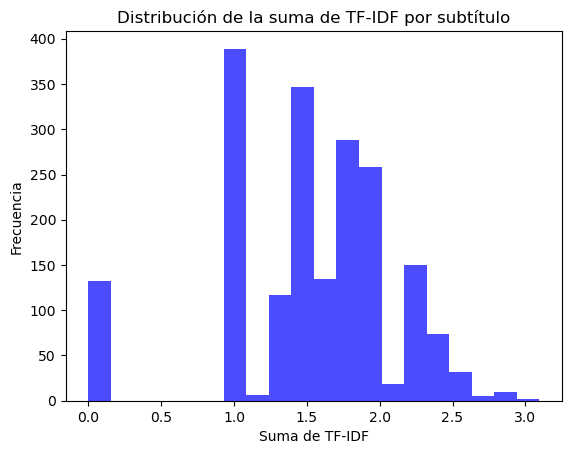

In [49]:
import matplotlib.pyplot as plt

plt.hist(df['tfidf_sum'], bins=20, color='blue', alpha=0.7)
plt.title('Distribución de la suma de TF-IDF por subtítulo')
plt.xlabel('Suma de TF-IDF')
plt.ylabel('Frecuencia')

plt.show()

Podemos separar subtítulos en rangos de TF-IDF y observar algunos para entender como se plasma esa diferencia en el índice.

In [50]:
threshold=1.5
subtitulos_altos = df[df['tfidf_sum'] > threshold]
subtitulos_bajos = df[df['tfidf_sum'] < threshold]

In [51]:
print('subtitulos_altos:')
subtitulos_altos[['subtitulo','subtitulo_es','tfidf_sum']].sample(5)

subtitulos_altos:


,subtitulo,subtitulo_es,tfidf_sum
1927,Okay.,bueno,1.994391
1949,Shut up.,callarse la boca,1.647164
605,"And then I met you guys, and you're like me.",Y luego los conocí a ustedes y son como yo.,2.204471
1569,Woo-hoo!,¡Guau!,2.203049
377,"-Hey. -Hey, buddy.","Hola, hola amigo",1.727821


Mi interpretación es que un alto TF-IDF resulta para subtítulos con gran valor de contenido impactante. Son como fraces que podemos recordar y asociar a la película.

In [52]:
print('subtitulos_bajos:')
subtitulos_bajos[['subtitulo','subtitulo_es','tfidf_sum']].sample(5)

subtitulos_bajos:


,subtitulo,subtitulo_es,tfidf_sum
633,Beer and tomato juice. Huh?,Cerveza y jugo de tomate ¿eh?,1.392941
671,She had to fly to Atlanta. She had a meeting at the NFL.,Ella tenía que volar a Atlanta porque tenía una reunión en la NFL.,1.337039
990,-Oh. -Everything's fine.,"Oh, todo está bien.",1.414152
1193,Mm. No. I'm really relieved that you said that.,"Mmm, no, realmente me siento aliviado de que hayas dicho eso.",1.000000
1709,...and it might have just been a hypothetical.,Y podría haber sido sólo una hipótesis.,1.414121


Para un bajo TF-IDF es todo lo contrario, en general son fraces menos impactantes.

#### Representación gráfica TF-IDF vs Sentimiento

En el siguiente gráfico se representa el eje x coincidente con el gráfico anterior pero en el se plasma la evaluación de sentimientos resultante.
De ésta manera se puede tener una visión general de como se distribuye el sentimiento en toda la película.

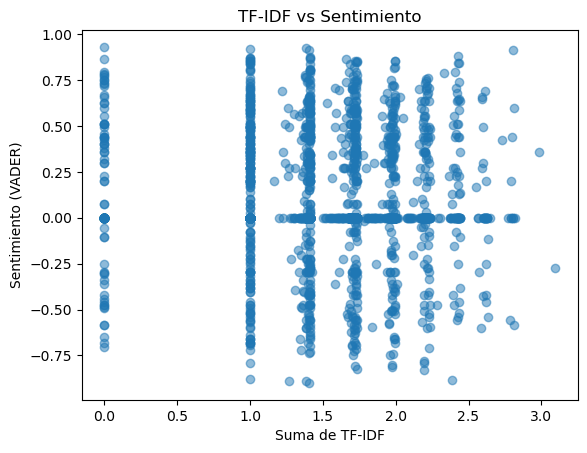

In [53]:
plt.scatter(df['tfidf_sum'], df['sentimientoVader'], alpha=0.5)
plt.title('TF-IDF vs Sentimiento')
plt.xlabel('Suma de TF-IDF')
plt.ylabel('Sentimiento (VADER)')
plt.show()

### Nube de Palabras

In [54]:
X = tfidf.fit_transform(df['subtituloLimpio1'])

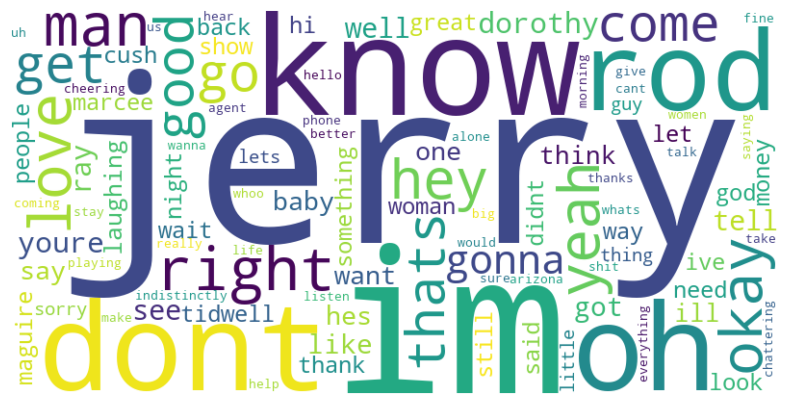

In [55]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Obtener las palabras y sus puntuaciones TF-IDF
# `get_feature_names_out()` da las palabras
# `toarray()` da las puntuaciones de TF-IDF
words = tfidf.get_feature_names_out()
# Sumar las puntuaciones de cada palabra
tfidf_scores = X.sum(axis=0).A1  

# Crear un diccionario de palabras con sus correspondientes puntuaciones
word_dict = dict(zip(words, tfidf_scores))

# Generar la nube de palabras con las palabras y puntuaciones obtenidas
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, colormap='viridis').generate_from_frequencies(word_dict)

# Visualizar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Ocultar los ejes
plt.show()